##Librerias

In [2]:
!pip install scikit-learn
!pip install collections
!pip install imblearn.over_sampling
!pip install -q streamlit pyngrok scikit-learn xgboost pandas

ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
ERROR: Could not find a version that satisfies the requirement imblearn.over_sampling (from versions: none)
ERROR: No matching distribution found for imblearn.over_sampling
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.4 MB/s eta 0:00:00


In [3]:
%%writefile app.py

Writing app.py


In [4]:
from pyngrok import ngrok
import threading
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import streamlit as st
from scipy.stats.mstats import winsorize
from scipy.stats import gaussian_kde
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import drive
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
import pickle
import plotly.express as px

# Nueva sección

##dataset

In [5]:
#drive.mount('/content/gdrive')
#csv_path = '/content/gdrive/MyDrive/Consultoría. Laboratorio/data/bank-additional-full.csv' # comentar el que no se use
csv_path = '/content/bank-additional-full.csv' # comentar el que no se use
data = pd.read_csv(csv_path, sep=";")

# Limpieza

## Datos Faltantes

In [6]:
print("La cantidad de NaNs por variable es: ")
print(data.isnull().sum())

La cantidad de NaNs por variable es: 
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


---

### Pocos NaNs

In [7]:
data["duration"]

,duration
0,261
1,149
2,226
3,151
4,307
...,...
41183,334
41184,383
41185,189
41186,442


In [8]:
data["marital"].value_counts()

,count
marital,
married,24928
single,11568
divorced,4612
unknown,80


In [9]:
data['job'].value_counts()

,count
job,
admin.,10422
blue-collar,9254
technician,6743
services,3969
management,2924
retired,1720
entrepreneur,1456
self-employed,1421
housemaid,1060


In [10]:
data["day_of_week"].value_counts()

,count
day_of_week,
thu,8623
mon,8514
wed,8134
tue,8090
fri,7827


In [11]:
data["contact"].value_counts()

,count
contact,
cellular,26144
telephone,15044


---

In [12]:
data['housing'].value_counts()


,count
housing,
yes,21576
no,18622
unknown,990


In [13]:
data["loan"].value_counts()

,count
loan,
no,33950
yes,6248
unknown,990


Los valores donde Housing es unknown, Loan tambien lo es.

In [14]:
data[(data["loan"] == "unknown")&(data["housing"] == "unknown")].shape

(990, 21)

---

In [15]:
data["month"].value_counts()

,count
month,
may,13769
jul,7174
aug,6178
jun,5318
nov,4101
apr,2632
oct,718
sep,570
mar,546


---

In [16]:
data["previous"].value_counts()

,count
previous,
0,35563
1,4561
2,754
3,216
4,70
5,18
6,5
7,1


### Analizar PDAYS

In [17]:
data["pdays"].value_counts()

,count
pdays,
999,39673
3,439
6,412
4,118
9,64
2,61
7,60
12,58
10,52


In [18]:
print(f"No fueron contactados (999):", data[data["pdays"]== 999].shape)
print(f"Fueron contactados:", data[data["pdays"] != 999].shape)

No fueron contactados (999): (39673, 21)
Fueron contactados: (1515, 21)


In [19]:
# Casos con pdays == 999 (no fue contactado) y previous > 0 (tuvo contactos)
data[(data['pdays'] == 999) & (data['previous'] > 0)].shape
# Elimino inconsistensias
data = data.drop(data[(data['pdays'] == 999) & (data['previous'] > 0)].index)

---

### Varios NaNs

In [20]:
data["poutcome"].value_counts()

,count
poutcome,
nonexistent,35563
success,1373
failure,142


Variable no servible¿

In [21]:
data["default"].value_counts()

,count
default,
no,28990
unknown,8086
yes,2


## Outliers

In [22]:
def detectar_outliers_iqr(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (serie < lower_bound) | (serie > upper_bound)


In [23]:
num_vars = ['age', 'campaign', 'previous', 'duration']
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

In [24]:
data_outliers = data.copy()
for variable in num_vars:
    outliers_mask = detectar_outliers_iqr(data[variable])
    data_outliers[f'is_outlier_{variable}'] = outliers_mask
    outliers = data[variable][outliers_mask]
    print(f"Cantidad de outliers en {variable}:", len(outliers))
    #Identificar porcentaje de estas cantidades en el df
    print(f"Porcentaje de outliers en {variable}:", (len(outliers)/len(data[variable]))*100)

Cantidad de outliers en age: 365
Porcentaje de outliers en age: 0.984411241167269
Cantidad de outliers en campaign: 2318
Porcentaje de outliers en campaign: 6.251685635686931
Cantidad de outliers en previous: 1515
Porcentaje de outliers en previous: 4.085980905118938
Cantidad de outliers en duration: 2653
Porcentaje de outliers en duration: 7.155186363881547


Desición tomada: marcar observaciones que tenga (al menos) una variable con un valor outlier como una observación con outlier. No se realizará ninguna eliminación para evitar sesgos en el modelo, generar robustez en el mismo ante datos de validación o despliegue a producción, y poseer una mejor visión de la realidad.

In [25]:
# drop columnas con is_outliers False en todas las observaciones
# data_outliers = data_outliers.drop(columns = ["is_outlier_euribor3m", "is_outlier_nr.employed", "is_outlier_emp.var.rate", "is_outlier_cons.price.idx"])
cols = ["is_outlier_euribor3m", "is_outlier_nr.employed", "is_outlier_emp.var.rate", "is_outlier_cons.price.idx"]
if all(col in data_outliers.columns for col in cols):
    data_outliers = data_outliers.drop(columns = ["is_outlier_euribor3m", "is_outlier_nr.employed", "is_outlier_emp.var.rate", "is_outlier_cons.price.idx"])
# Crear columna is_outlier con la condicion: is_outliers_age == True or is_outlier_campaign == True or is_outlier_pdays ==True or is_outlier_previous == True or is_outliers_duration ==True or is_outlier_cons.conf.idx ==True
# data_outliers['is_outlier'] = data_outliers[['is_outlier_age', 'is_outlier_campaign', 'is_outlier_pdays', 'is_outlier_previous', 'is_outlier_duration', 'is_outlier_cons.conf.idx']].any(axis=1)

cols_2 = ['is_outlier_age', 'is_outlier_campaign', 'is_outlier_pdays',
        'is_outlier_previous', 'is_outlier_duration', 'is_outlier_cons.conf.idx']

# Filtramos solo las columnas que realmente están en el DataFrame
existing_cols = [col for col in cols_2 if col in data_outliers.columns]

# Aplicamos .any() solo sobre esas columnas
data_outliers['is_outlier'] = data_outliers[existing_cols].any(axis=1)

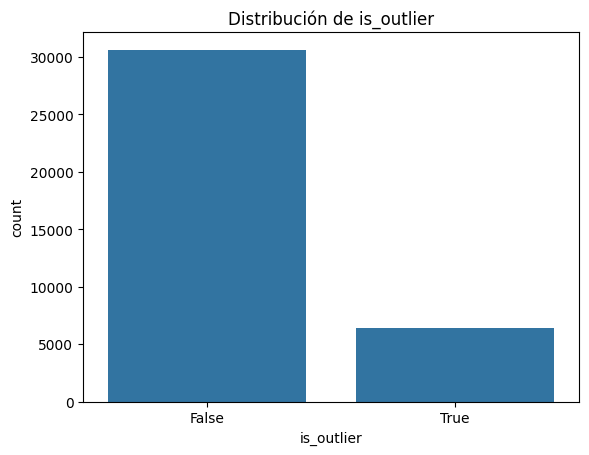

In [26]:
#agregar la columna is_outlier a data
data['is_outlier'] = data_outliers['is_outlier']
#ver distribución de data_outliers.is_outlier
sns.countplot(data=data, x='is_outlier')
plt.title("Distribución de is_outlier")
plt.show()

In [27]:
print("Edad mínima:", data['age'].min())
print("Edad máxima:", data['age'].max())

Edad mínima: 17
Edad máxima: 98


Cuando la duración del último contacto fue 0, también tuvo 0 contactos (previous) y no fue contactado (pdays)

In [28]:
data[(data["duration"] == 0)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,is_outlier
6251,39,admin.,married,high.school,no,yes,no,telephone,may,tue,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,False
23031,59,management,married,university.degree,no,yes,no,cellular,aug,tue,...,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no,True
28063,53,blue-collar,divorced,high.school,no,yes,no,cellular,apr,fri,...,999,0,nonexistent,-1.8,93.075,-47.1,1.479,5099.1,no,False
33015,31,blue-collar,married,basic.9y,no,no,no,cellular,may,mon,...,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,no,False


In [29]:
# Duplicados
print("Duplicados exactos:", data.duplicated().sum())
data[data.duplicated()].shape

Duplicados exactos: 12


(12, 22)

# Feature engineering

## Feature construction

In [30]:
# Total de contactos
data['contactosTotales'] = data['campaign'] + data['previous']


# Campañas exitosas previas
data['campañasExitosasPrevias'] = ((data['poutcome'] == 'success') & (data['previous'] > 0)).astype(int)
data["campañasExitosasPrevias"]

,campañasExitosasPrevias
0,0
1,0
2,0
3,0
4,0
...,...
41182,1
41183,0
41184,0
41185,0


## Encoding

In [31]:
encode = data.copy()
encode.drop(columns=['is_outlier', 'default',"poutcome"], inplace=True)
encode.dtypes.to_frame()

,0
age,int64
job,object
marital,object
education,object
housing,object
loan,object
contact,object
month,object
day_of_week,object
duration,int64


In [32]:
encode.sample(5)

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,...,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,contactosTotales,campañasExitosasPrevias
10421,34,admin.,married,university.degree,yes,no,telephone,jun,mon,14,...,999,0,1.4,94.465,-41.8,4.960,5228.1,no,14,0
21713,41,technician,single,professional.course,no,yes,cellular,aug,tue,102,...,999,0,1.4,93.444,-36.1,4.963,5228.1,no,3,0
27578,59,technician,single,professional.course,yes,no,cellular,nov,fri,246,...,999,0,-0.1,93.200,-42.0,4.021,5195.8,no,2,0
19468,32,admin.,single,university.degree,yes,yes,cellular,aug,thu,51,...,999,0,1.4,93.444,-36.1,4.968,5228.1,no,2,0
5774,25,self-employed,single,university.degree,no,no,telephone,may,mon,78,...,999,0,1.1,93.994,-36.4,4.857,5191.0,no,2,0


## target

In [33]:
encode['y'] = encode['y'].astype(str)
encode['y'] = encode['y'].map({'no': 0, 'yes': 1})

## occupation

In [34]:
categorical_cols = encode.select_dtypes(include=['object']).columns
cardinality = {}
for col in categorical_cols:
    cardinality[col] = encode[col].nunique()


for col, card in cardinality.items():
    print(f"{col}: {card}")

job: 12
marital: 4
education: 8
housing: 3
loan: 3
contact: 2
month: 10
day_of_week: 5


### previous

In [35]:
encode["previous"].value_counts()

,count
previous,
0,35563
1,865
2,405
3,166
4,58
5,16
6,4
7,1


In [36]:
#Binning de previous
encode['previous_bin'] = pd.cut(data['previous'], bins=[-1, 0, 2, np.inf], labels=[0, 1, 2])
encode["previous_bin"] = encode["previous_bin"].astype(int)
encode["previous_bin"].value_counts()
# 0: Nada (0 contactos)
# 1: Poco (1 o 2 contactos)
# 2: Mucho (3-7)

,count
previous_bin,
0,35563
1,1270
2,245


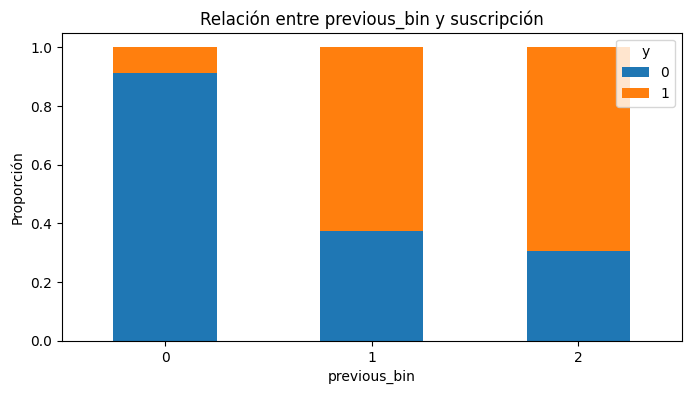

In [37]:
#relacion con variable objetivo
for col in ['previous_bin']:
    ct = pd.crosstab(encode[col], encode['y'], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(8, 4))
    plt.title(f'Relación entre {col} y suscripción')
    plt.ylabel('Proporción')
    plt.xticks(rotation=0)
    plt.show()

### Job

In [38]:
job_target_mean = encode.groupby('job')['y'].mean()
encode['job_target_mean'] = encode['job'].map(job_target_mean)


encode.drop('job', axis=1, inplace=True)
encode.head()

,age,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,contactosTotales,campañasExitosasPrevias,previous_bin,job_target_mean
0,56,married,basic.4y,no,no,telephone,may,mon,261,1,...,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0.097068
1,57,married,high.school,no,no,telephone,may,mon,149,1,...,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0.081089
2,37,married,high.school,yes,no,telephone,may,mon,226,1,...,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0.081089
3,40,married,basic.6y,no,no,telephone,may,mon,151,1,...,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0.128895
4,56,married,high.school,no,yes,telephone,may,mon,307,1,...,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0.081089


### Marital

In [39]:
marital_dummies = pd.get_dummies(encode['marital'], prefix='marital', dtype=int)
encode = pd.concat([encode, marital_dummies], axis=1)
encode.drop('marital', axis=1, inplace=True)
encode.head()

,age,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,...,nr.employed,y,contactosTotales,campañasExitosasPrevias,previous_bin,job_target_mean,marital_divorced,marital_married,marital_single,marital_unknown
0,56,basic.4y,no,no,telephone,may,mon,261,1,999,...,5191.0,0,1,0,0,0.097068,0,1,0,0
1,57,high.school,no,no,telephone,may,mon,149,1,999,...,5191.0,0,1,0,0,0.081089,0,1,0,0
2,37,high.school,yes,no,telephone,may,mon,226,1,999,...,5191.0,0,1,0,0,0.081089,0,1,0,0
3,40,basic.6y,no,no,telephone,may,mon,151,1,999,...,5191.0,0,1,0,0,0.128895,0,1,0,0
4,56,high.school,no,yes,telephone,may,mon,307,1,999,...,5191.0,0,1,0,0,0.081089,0,1,0,0


### Education

In [40]:
education_counts = encode['education'].value_counts(normalize=True)
encode['education_freq_encode'] = encode['education'].map(education_counts)
encode.drop('education', axis=1, inplace=True)
encode.head()

,age,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,...,y,contactosTotales,campañasExitosasPrevias,previous_bin,job_target_mean,marital_divorced,marital_married,marital_single,marital_unknown,education_freq_encode
0,56,no,no,telephone,may,mon,261,1,999,0,...,0,1,0,0,0.097068,0,1,0,0,0.103458
1,57,no,no,telephone,may,mon,149,1,999,0,...,0,1,0,0,0.081089,0,1,0,0,0.227466
2,37,yes,no,telephone,may,mon,226,1,999,0,...,0,1,0,0,0.081089,0,1,0,0,0.227466
3,40,no,no,telephone,may,mon,151,1,999,0,...,0,1,0,0,0.128895,0,1,0,0,0.056017
4,56,no,yes,telephone,may,mon,307,1,999,0,...,0,1,0,0,0.081089,0,1,0,0,0.227466


### Housing, Loan y Contact

In [41]:
housing_dummies = pd.get_dummies(encode['housing'], prefix='housing', dtype=int)
loan_dummies = pd.get_dummies(encode['loan'], prefix='loan', dtype=int)
contact_dummies = pd.get_dummies(encode['contact'], prefix='contact', dtype=int)

encode = pd.concat([encode, housing_dummies, loan_dummies, contact_dummies], axis=1)

encode.drop(['housing', 'loan', 'contact'], axis=1, inplace=True)

encode.head()

,age,month,day_of_week,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,marital_unknown,education_freq_encode,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone
0,56,may,mon,261,1,999,0,1.1,93.994,-36.4,...,0,0.103458,1,0,0,1,0,0,0,1
1,57,may,mon,149,1,999,0,1.1,93.994,-36.4,...,0,0.227466,1,0,0,1,0,0,0,1
2,37,may,mon,226,1,999,0,1.1,93.994,-36.4,...,0,0.227466,0,0,1,1,0,0,0,1
3,40,may,mon,151,1,999,0,1.1,93.994,-36.4,...,0,0.056017,1,0,0,1,0,0,0,1
4,56,may,mon,307,1,999,0,1.1,93.994,-36.4,...,0,0.227466,1,0,0,0,0,1,0,1


### Month y Day of Week

In [42]:
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
encode['month'] = encode['month'].map(month_mapping)


day_mapping = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5}
encode['day_of_week'] = encode['day_of_week'].map(day_mapping)

### Sacar outliers

In [43]:
# def remove_outliers_iqr(df):
#     df_no_outliers = df.copy()
#     for col in df_no_outliers.columns:
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]
#     return df_no_outliers

def remove_outliers_iqr(df):
    df_no_outliers = df.copy()
    numeric_cols = df_no_outliers.select_dtypes(include=np.number).columns # Filter for numeric columns only
    for col in numeric_cols: # Iterate over numeric columns
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]
    return df_no_outliers


encode_no_outliers = remove_outliers_iqr(encode)

### Correlación Encoding

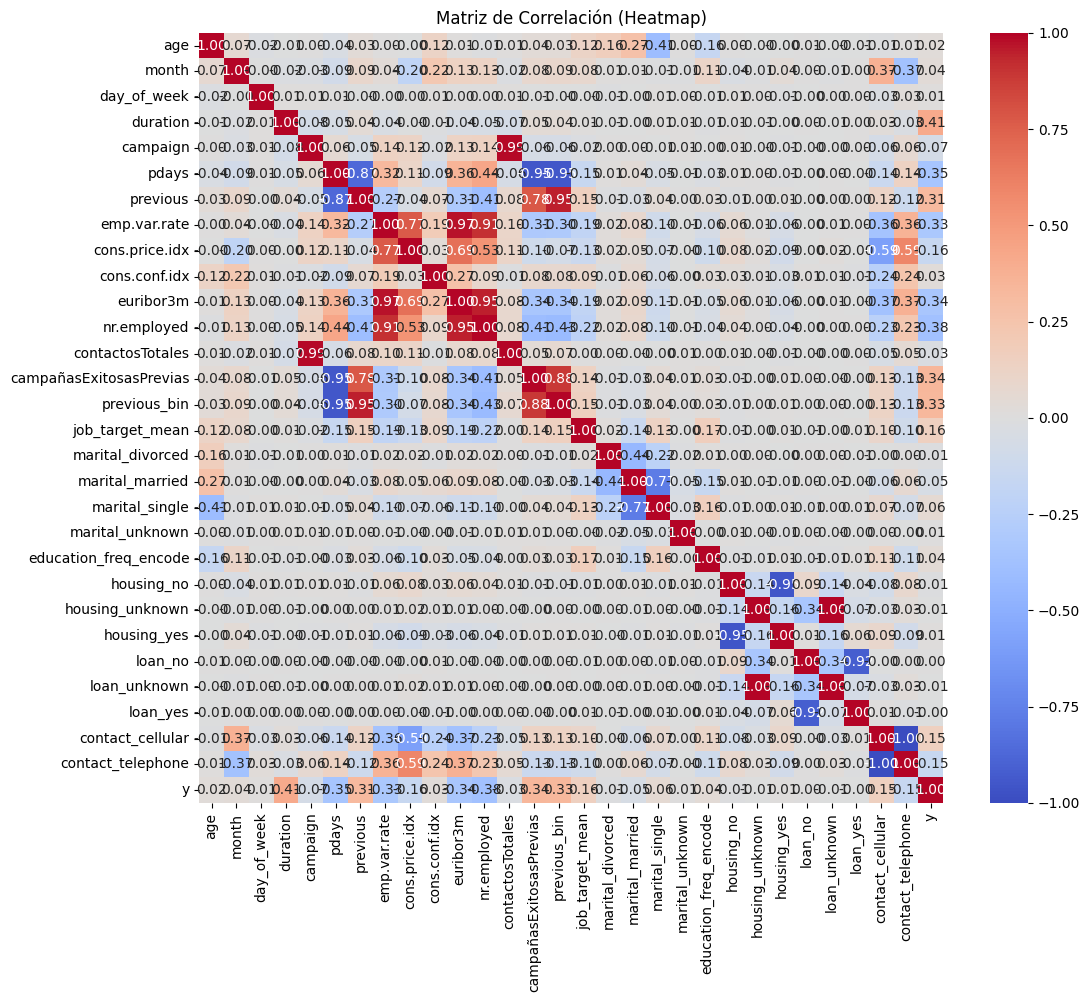

In [44]:
numericas = encode_no_outliers.select_dtypes(include=['int64', 'float64']).columns
numericas = numericas.drop('y')
numericas = encode[numericas.tolist()  + ['y']] # para que quede y al final|


correlation_matrix = numericas.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de Correlación (Heatmap)')
plt.show()

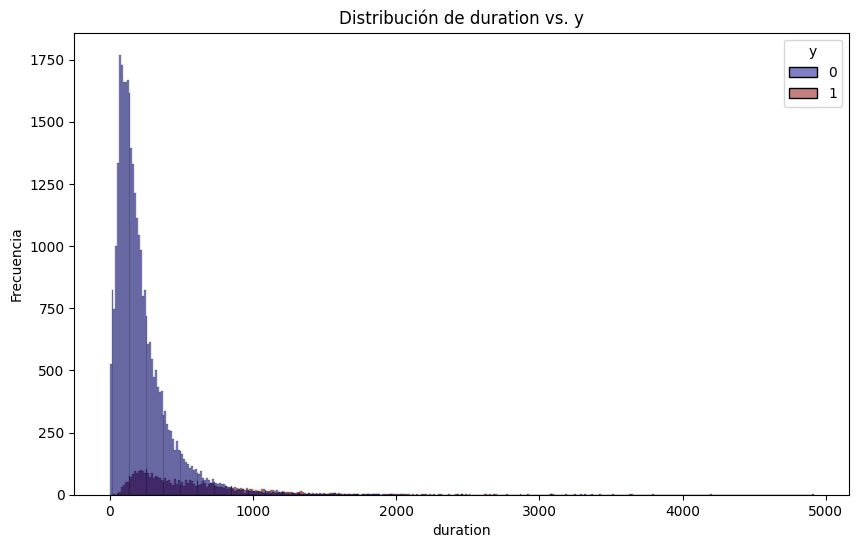

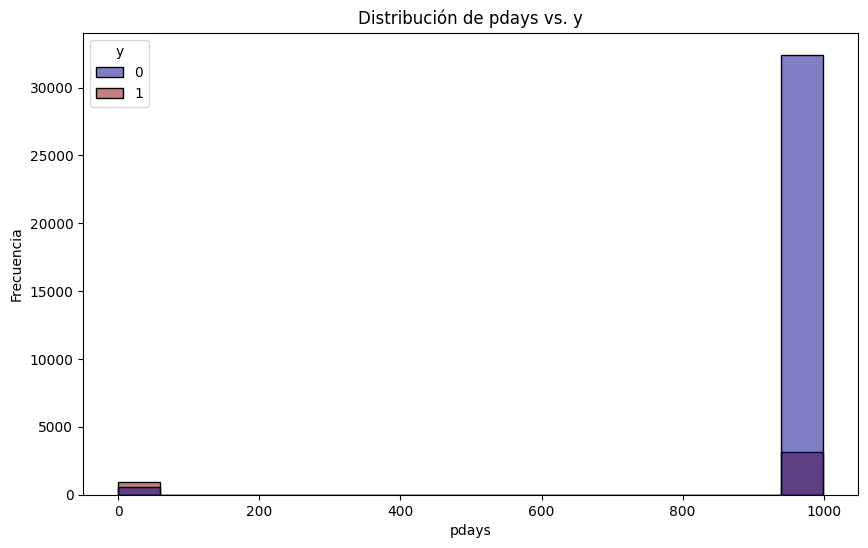

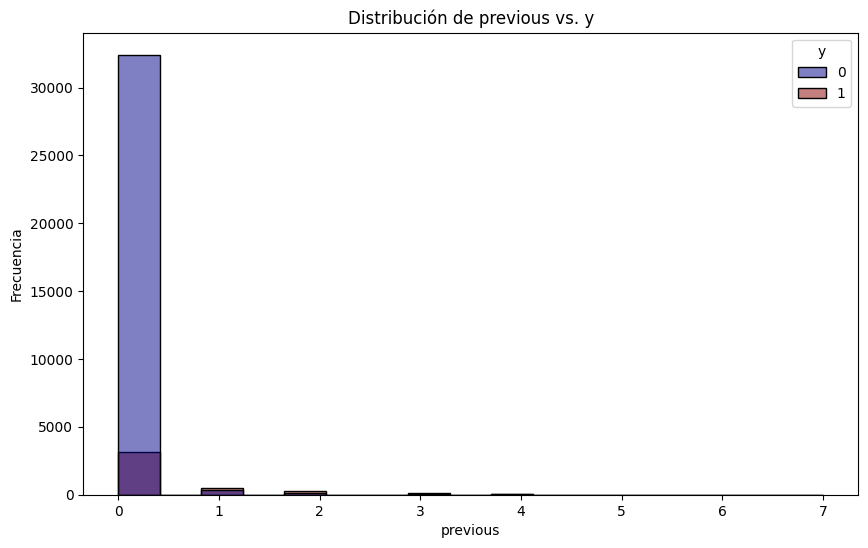

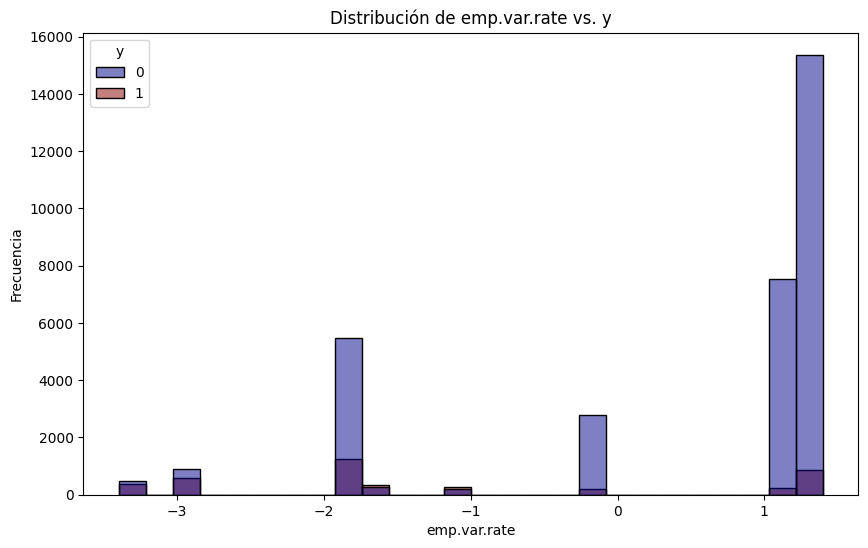

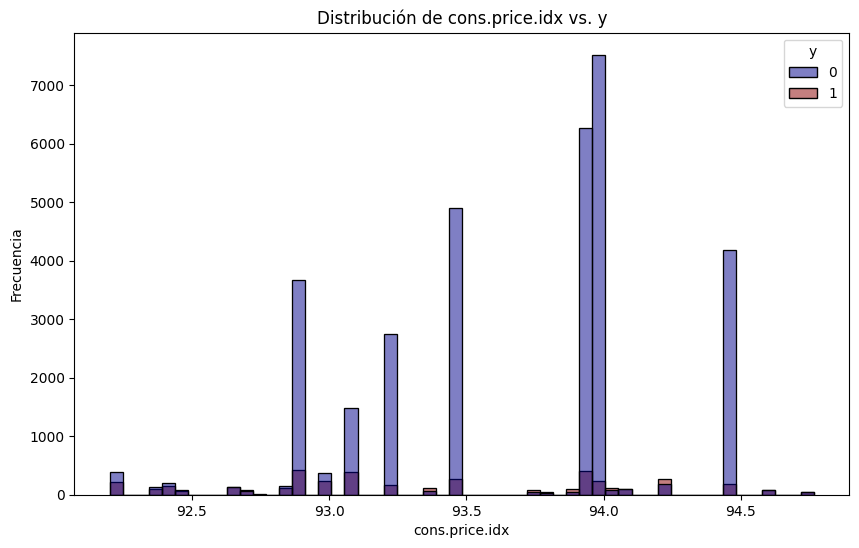

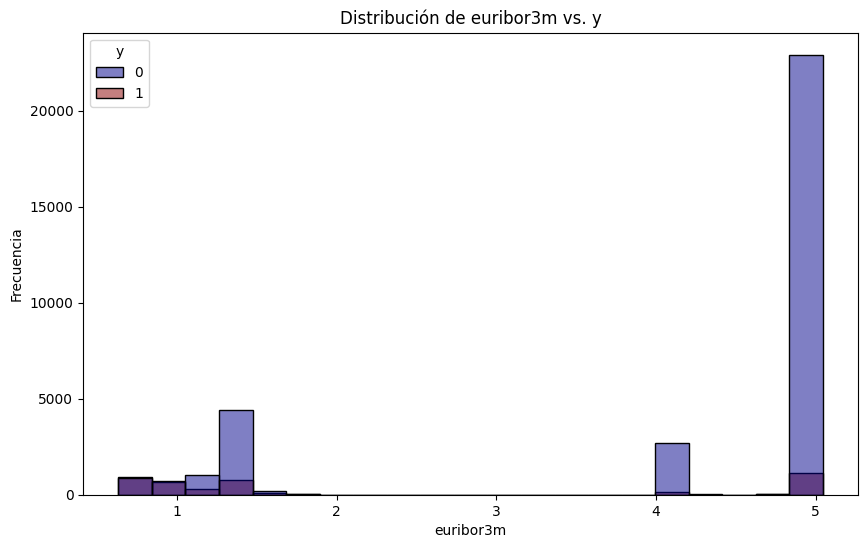

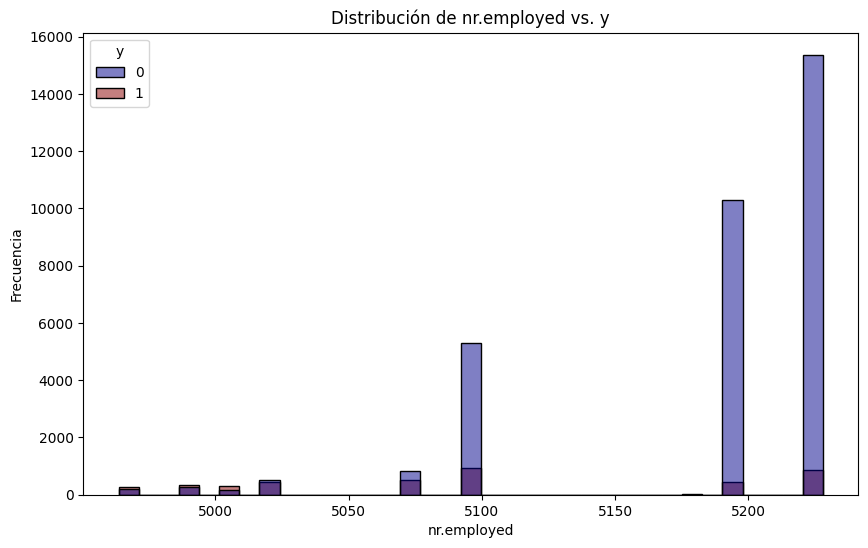

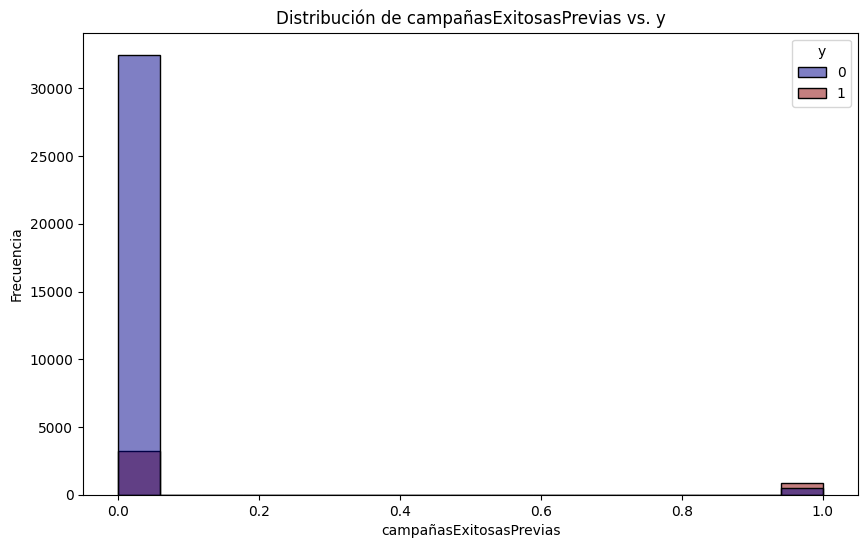

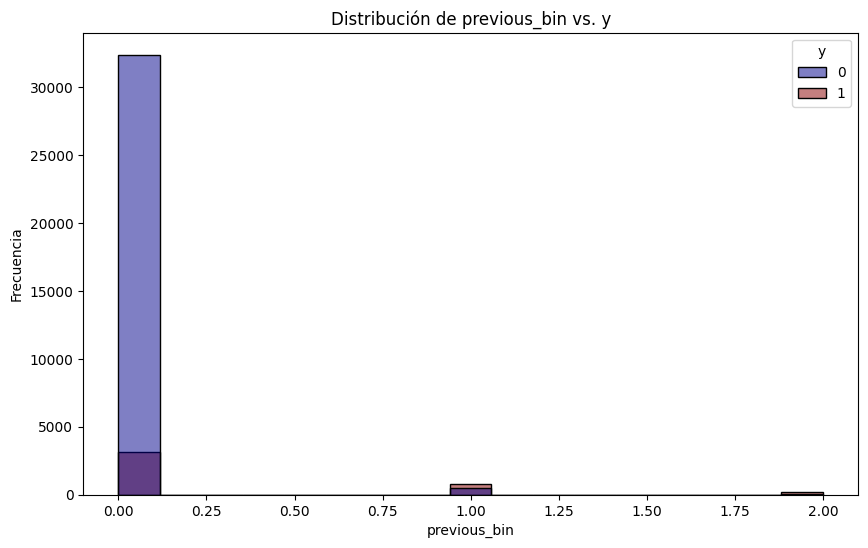

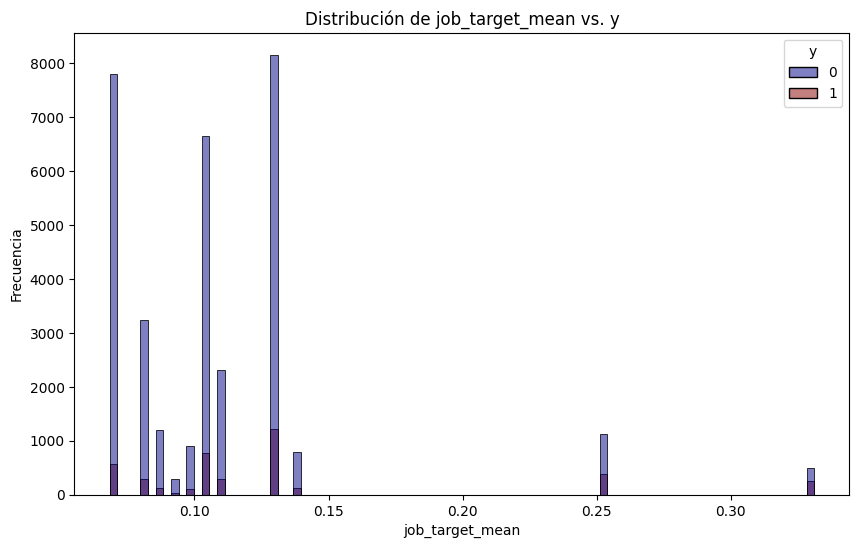

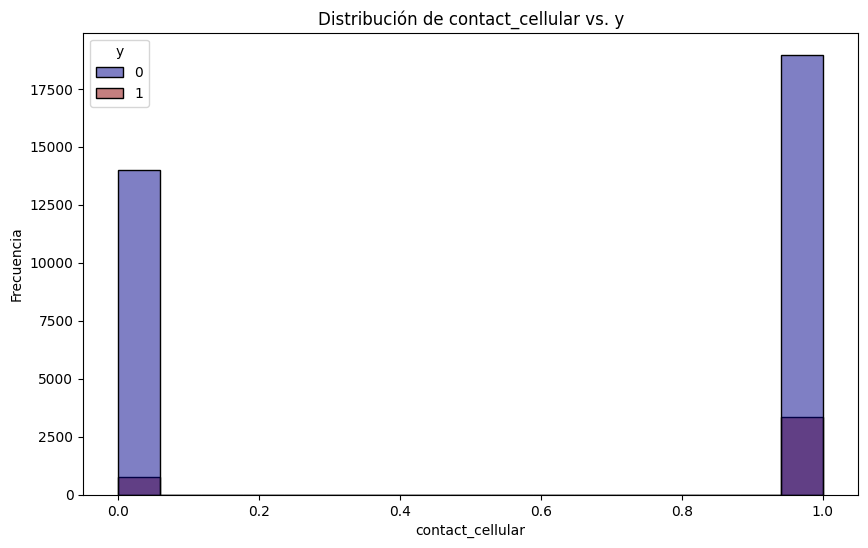

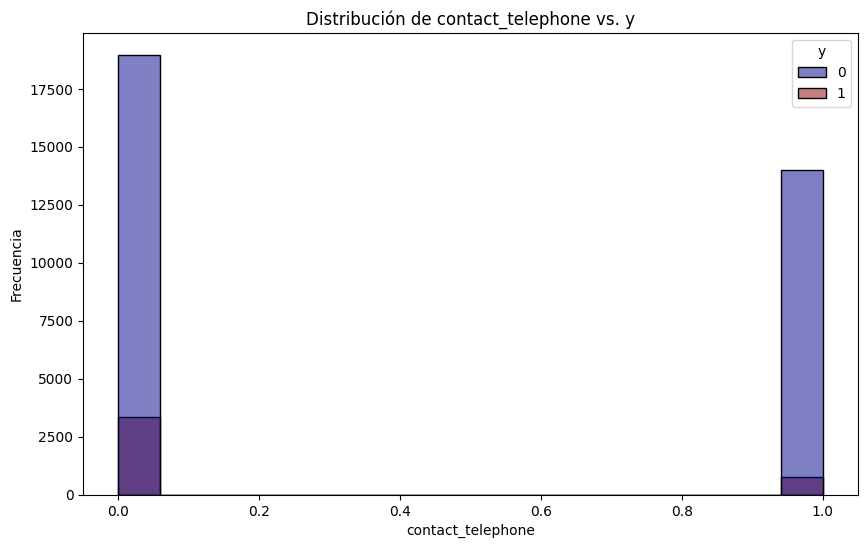

In [45]:
correlation_with_y = correlation_matrix['y'].abs()
relevant_variables = correlation_with_y[correlation_with_y > 0.1].index.drop('y')


for variable in relevant_variables:
  plt.figure(figsize=(10, 6))


  if pd.api.types.is_numeric_dtype(encode[variable]):
    sns.histplot(x=variable, hue='y', data=encode, palette=['darkblue', 'darkred'])

  else:
    sns.countplot(x=variable, hue='y', data=encode, palette=['darkblue', 'darkred'])
  plt.title(f'Distribución de {variable} vs. y')
  plt.xlabel(variable)
  plt.ylabel('Frecuencia')
  plt.show()

Se agregaron las columnas

1.   contactosTotales para ver cuantas veces se lo contacto previamente
2.   fueContactado para ver si antes se lo habia contactado
3. campañasExitosasprevias
4. segmento que divide los clientes segun socioeconomia (es media basica la division)
5. mesNumero pase los meses a numeros 1=enero; 2=febrero y asi
6. hay algunas que tienen log, log2, winz_log, bin que son las que modifique en base al skew

---

### Análisis Relación Variable Objetivo (Y)

relacion de variables con la variable objetivo

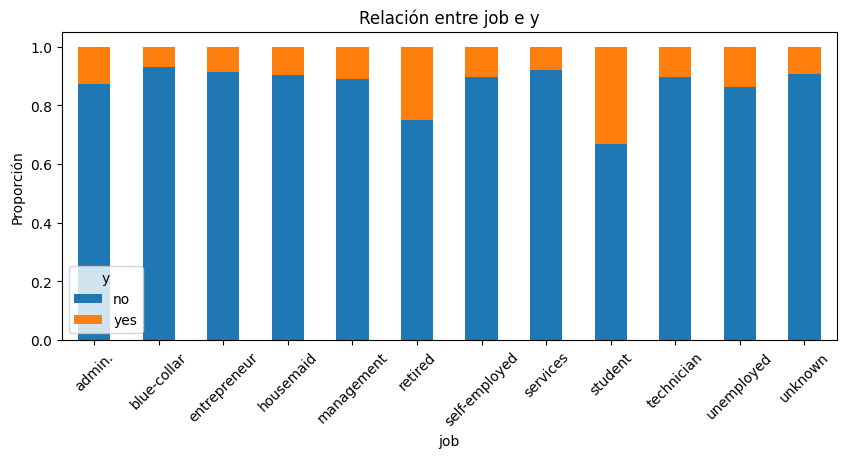

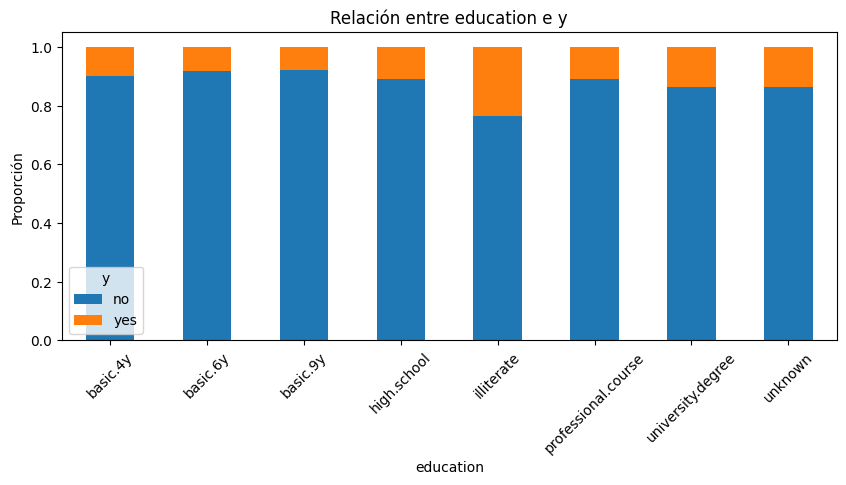

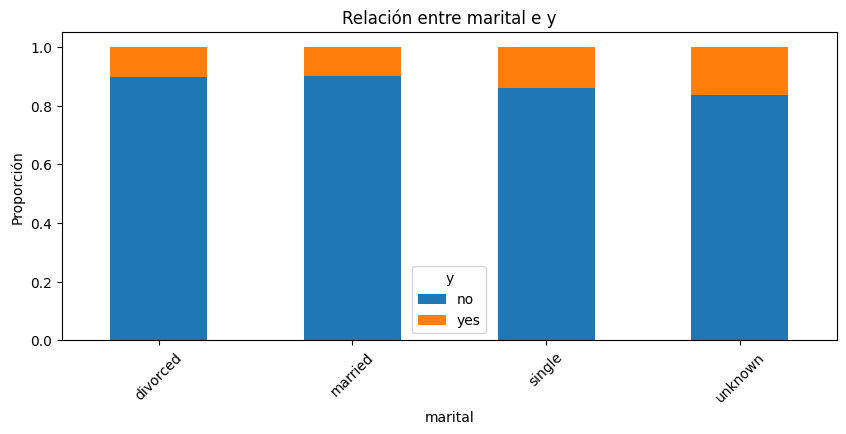

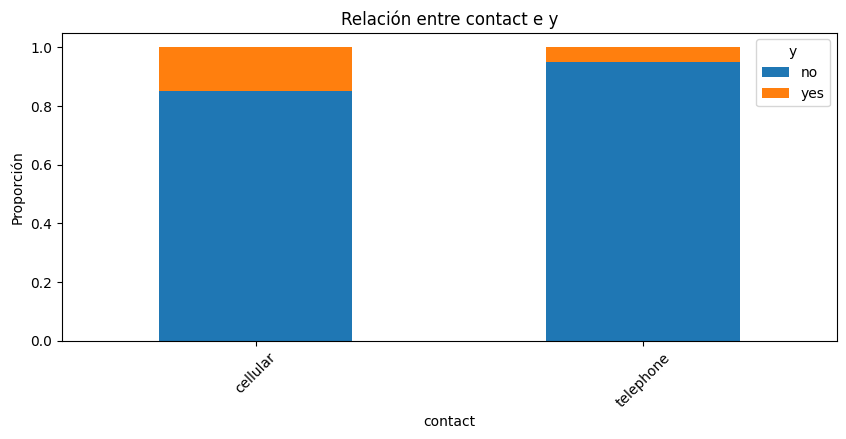

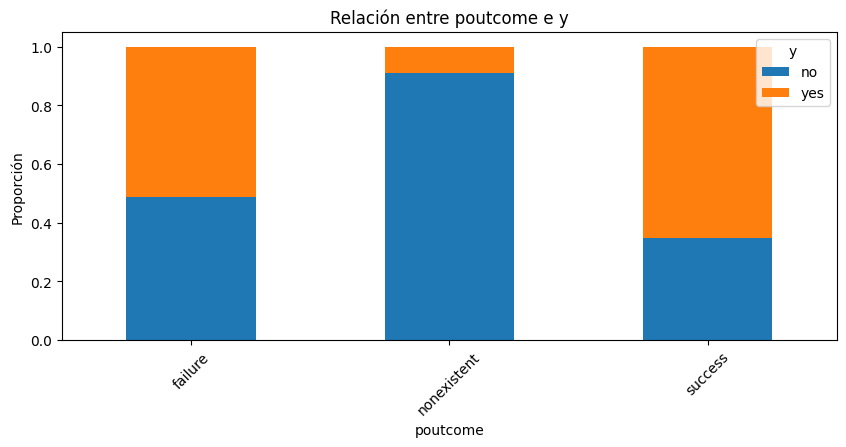

In [46]:
for col in ['job', 'education', 'marital','contact', 'poutcome']:
    ct = pd.crosstab(data[col], data['y'], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(10, 4))
    plt.title(f'Relación entre {col} e y')
    plt.ylabel('Proporción')
    plt.xticks(rotation=45)
    plt.show()

### Pruebas de Modelo

In [47]:
X = encode # [relevant_variables.tolist()]

## prueba de modelo con random sampling

In [48]:
X = encode
X_yes = X[X['y'] == 1]
X_no = X[X['y'] == 0].sample(n=len(X_yes), random_state=42)
X_balanced = pd.concat([X_yes, X_no])
y_balanced = X_balanced['y']
X_balanced = X_balanced.drop('y', axis=1)
X_balanced = X_balanced[relevant_variables.tolist()]

# Data augmentation


In [49]:
#Identificar variables más importantes en relación a la categoría "yes"

# Copia del dataset
df_model = data.copy()

# Codificar variables categóricas
label_encoders = {}
for col in df_model.select_dtypes(include='object').columns:
    if col != 'y':
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le

# Codificar target
df_model['y'] = df_model['y'].map({'no': 0, 'yes': 1})

# Entrenamiento
X = df_model.drop(columns='y')
y = df_model['y']
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Importancia
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top variables más importantes:\n", importances.head(10))

# Elegimos las 5 más importantes
top_features = importances.head(5).index.tolist()

Top variables más importantes:
 duration            0.263892
euribor3m           0.107965
age                 0.086509
nr.employed         0.064620
job                 0.047114
is_outlier          0.046794
education           0.041806
day_of_week         0.040489
contactosTotales    0.037793
campaign            0.037138
dtype: float64


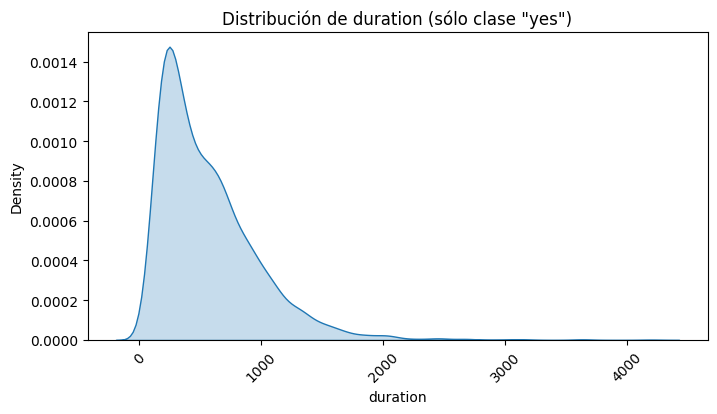

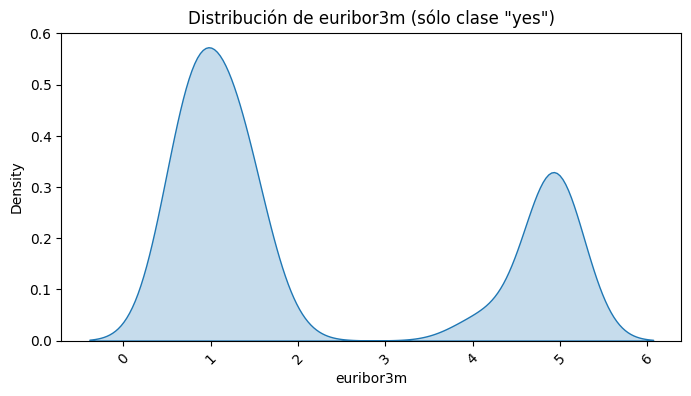

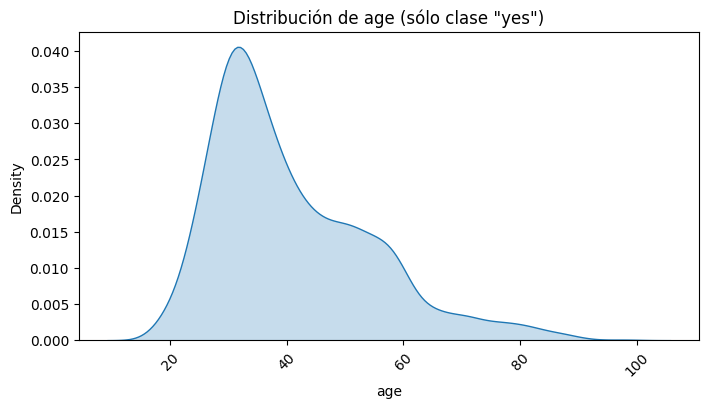

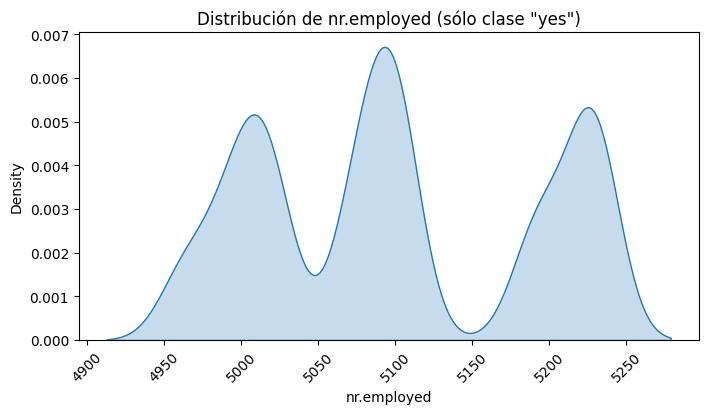

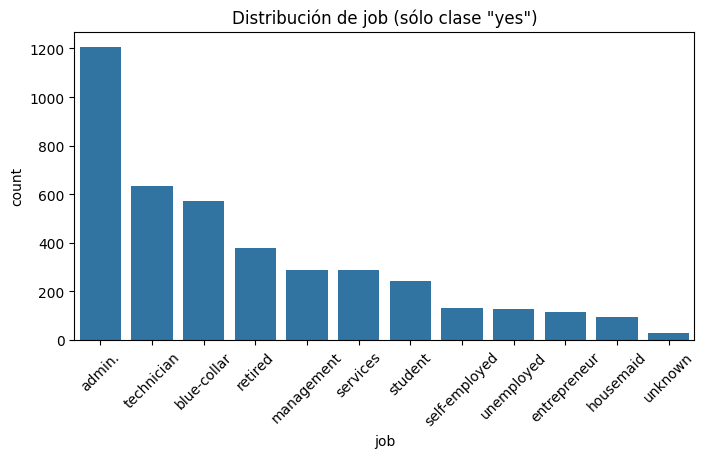

In [50]:
#Analizar distribución de las variables para comparar con el post data augmentation

df_yes = data[data['y'] == 'yes']

for col in top_features:
    plt.figure(figsize=(8, 4))
    if data[col].dtype == 'object':
        sns.countplot(data=df_yes, x=col, order=df_yes[col].value_counts().index)
    else:
        sns.kdeplot(df_yes[col].dropna(), fill=True)
    plt.title(f'Distribución de {col} (sólo clase "yes")')
    plt.xticks(rotation=45)
    plt.show()


y
no     0.7
yes    0.3
Name: proportion, dtype: float64


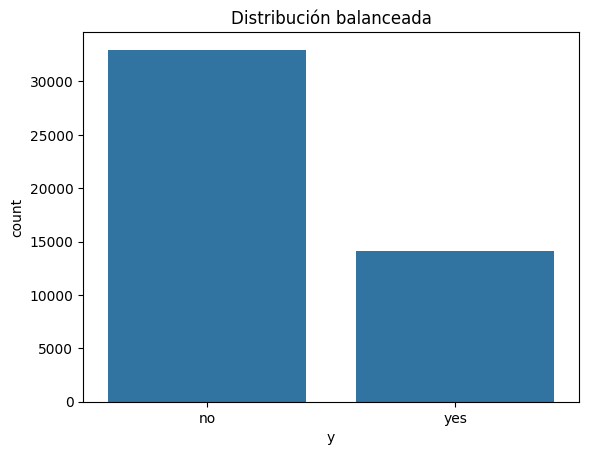

In [51]:
#Generación de los datos

# Cuántos nuevos generar
n_no = data[data['y'] == 'no'].shape[0]
n_yes = df_yes.shape[0]
numerador = 0.3 * n_no - 0.7 * n_yes
n_synthetic = int(numerador / 0.7)


# Variables categóricas y numéricas de interés
top_num = [col for col in top_features if data[col].dtype != 'object']
top_cat = [col for col in top_features if data[col].dtype == 'object']

# KDEs por columna numérica
kde_dict = {col: gaussian_kde(df_yes[col].dropna()) for col in top_num}

# Generación
synthetic_rows = []
for _ in range(n_synthetic):
    row = {}
    for col in top_num:
        row[col] = kde_dict[col].resample(1)[0][0]
    for col in top_cat:
        row[col] = np.random.choice(
            df_yes[col].dropna().unique(),
            p=df_yes[col].value_counts(normalize=True).values
        )
    row['y'] = 'yes'
    synthetic_rows.append(row)

df_synth_partial = pd.DataFrame(synthetic_rows)

# Agregar columnas faltantes (rellenarlas desde datos reales "yes" al azar)
for col in data.columns:
    if col not in df_synth_partial.columns:
        df_synth_partial[col] = np.random.choice(df_yes[col].dropna().values, size=n_synthetic)

# Reordenar columnas
df_synth_partial = df_synth_partial[data.columns]

# Unir dataset
data_balanced = pd.concat([data, df_synth_partial], ignore_index=True)

# Verificar
print(data_balanced['y'].value_counts(normalize=True))
sns.countplot(data=data_balanced, x='y')
plt.title("Distribución balanceada")
plt.show()


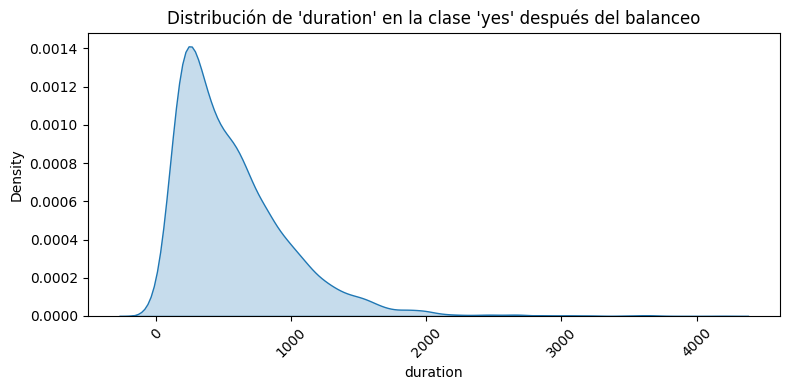

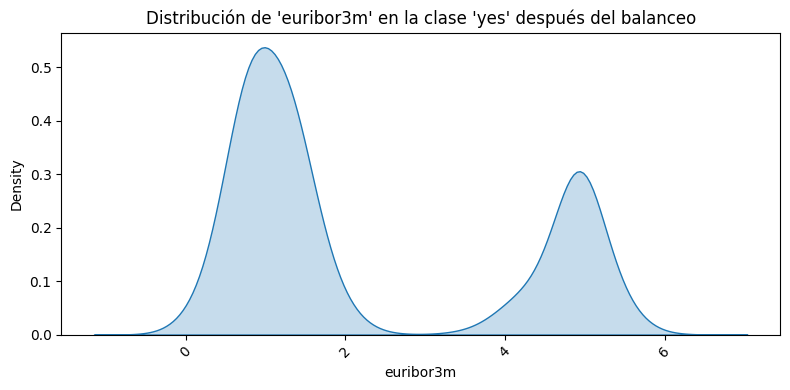

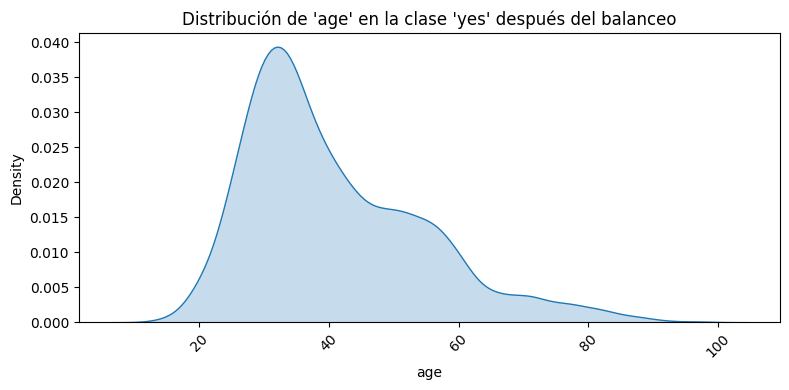

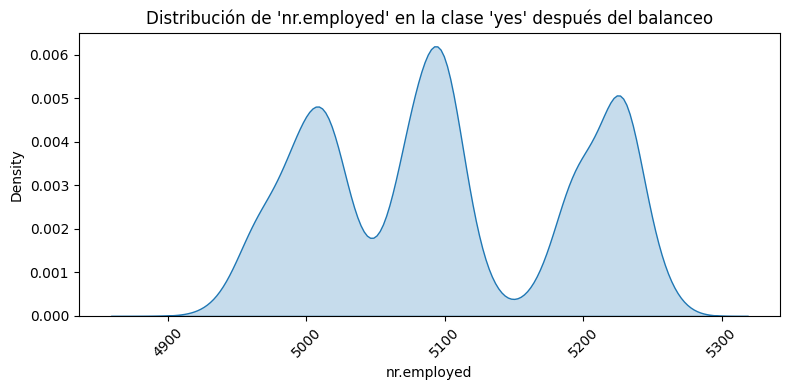

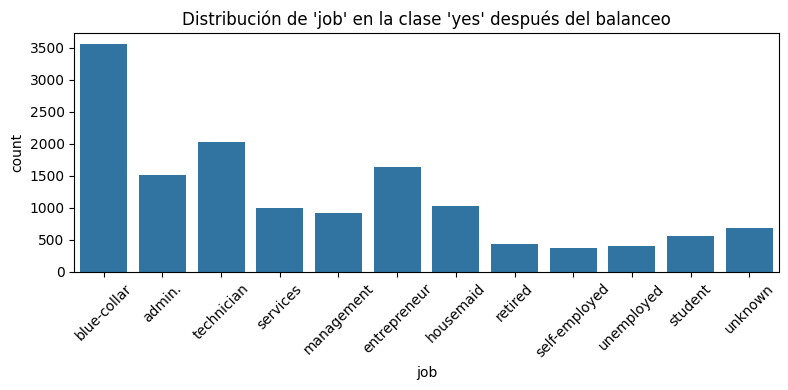

In [52]:
#Analizar distribución de las variables para comparar con el pre data augmentation

df_yes_final = data_balanced[data_balanced['y'] == 'yes']
for col in top_features:
    plt.figure(figsize=(8, 4))
    if data_balanced[col].dtype == 'object':
        sns.countplot(data=df_yes_final, x=col,
                      order=data_balanced[col].dropna().value_counts().index)
    else:
        sns.kdeplot(data=df_yes_final, x=col, fill=True)
    plt.title(f"Distribución de '{col}' en la clase 'yes' después del balanceo")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [53]:
#Distribuciones y totales numéricos

print("Distribución final de la variable 'y':")
print(data_balanced['y'].value_counts())

print("\nProporciones:")
print(data_balanced['y'].value_counts(normalize=True))

print("\nCantidad total de observaciones:")
print(len(data_balanced))

Distribución final de la variable 'y':
y
no     32970
yes    14130
Name: count, dtype: int64

Proporciones:
y
no     0.7
yes    0.3
Name: proportion, dtype: float64

Cantidad total de observaciones:
47100


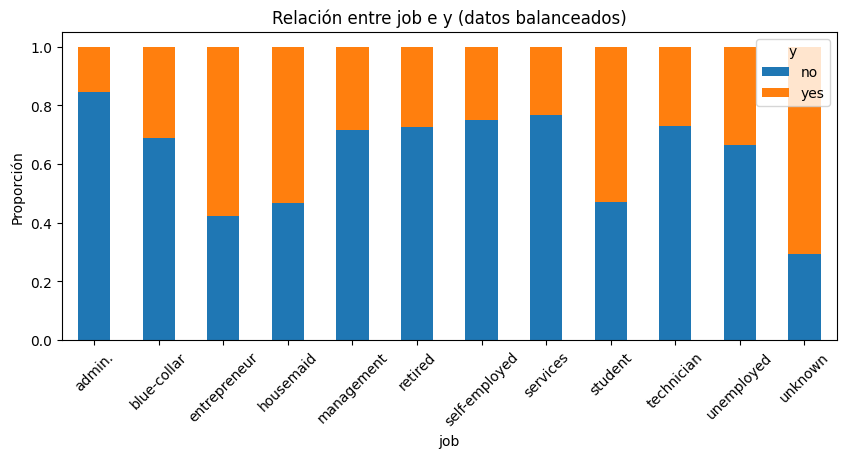

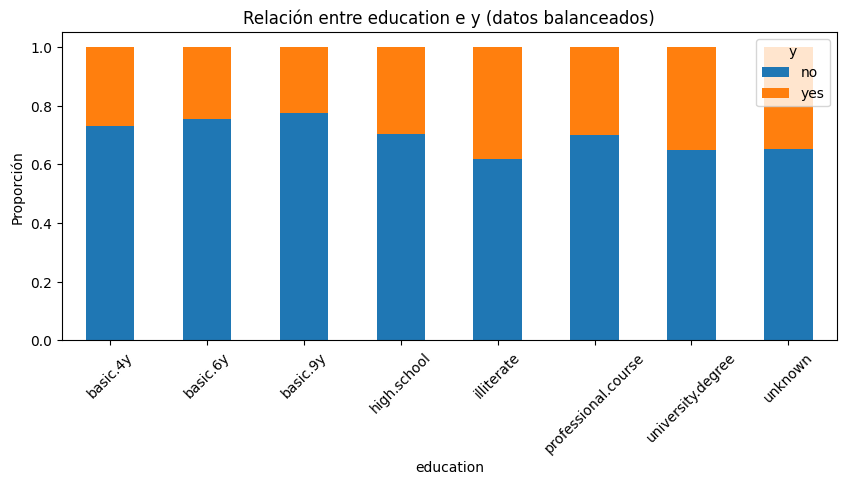

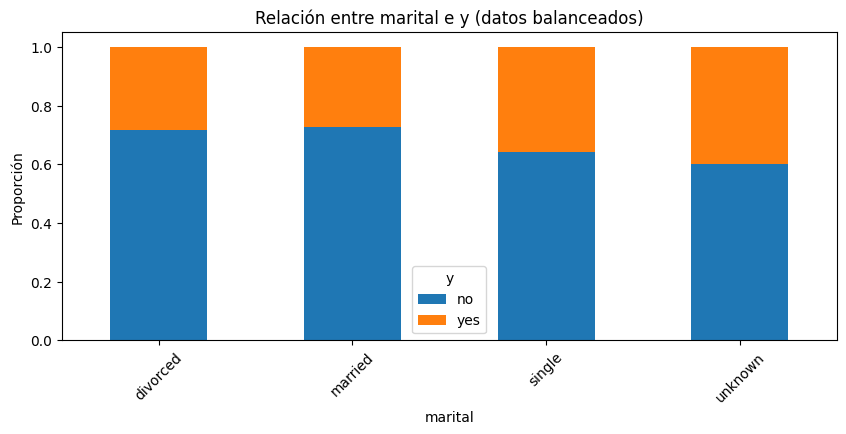

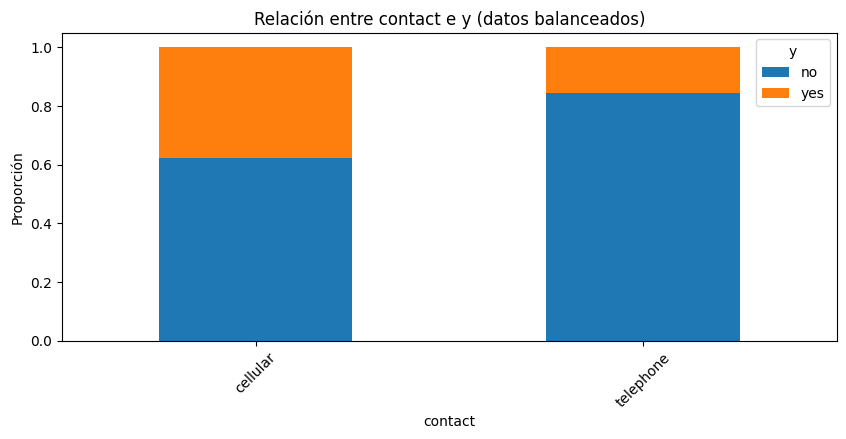

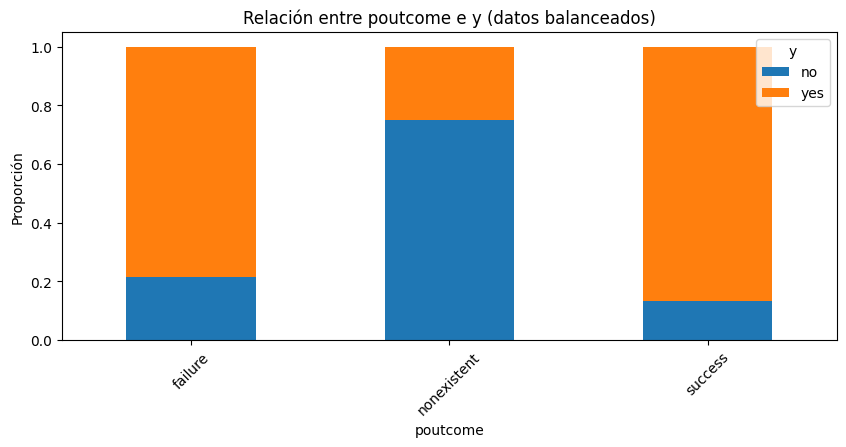

In [54]:
#Relación de variables con la objetivo balanceada para comparar con el pre data augmentation

for col in ['job', 'education', 'marital', 'contact', 'poutcome']:
    ct = pd.crosstab(data_balanced[col], data_balanced['y'], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(10, 4))
    plt.title(f'Relación entre {col} e y (datos balanceados)')
    plt.ylabel('Proporción')
    plt.xticks(rotation=45)
    plt.show()

# aplicar tecnicas de oversampleo

### SMOTE

In [55]:
x = encode
smote_df = x.copy()
smote_df_y = smote_df['y']
smote_df_x = smote_df.drop('y', axis=1)

In [56]:
smote = SMOTE(sampling_strategy = 0.3, random_state=42)
X_resampled, y_resampled = smote.fit_resample(smote_df_x, smote_df_y)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

In [58]:
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
print(f"Accuracy: {accuracy}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")

Accuracy: 0.9269800536568296
Sensitivity: 0.824847250509165
Specificity: 0.9573309123921925
Precision: 0.8517350157728707


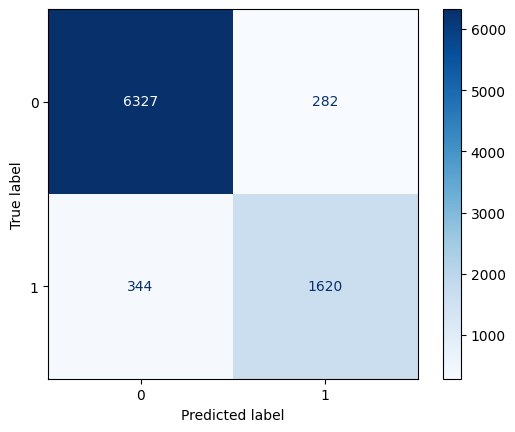

In [59]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

In [60]:
# F1-score macro (promedio de clases)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1 macro: {f1_macro:.4f}")

# Reporte completo
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

F1 macro: 0.8955

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      6609
           1       0.85      0.82      0.84      1964

    accuracy                           0.93      8573
   macro avg       0.90      0.89      0.90      8573
weighted avg       0.93      0.93      0.93      8573



# Feature selection

## PCA

In [61]:
X = X_resampled.copy()
y = y_resampled.copy()

In [62]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [63]:
pca = PCA()
X_pca = pca.fit_transform(X)

In [64]:
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X)

In [65]:
def modelo(x, y):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    xgb_model = XGBClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=6,
        use_label_encoder=False, eval_metric='logloss', random_state=42
    )
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    y_proba = xgb_model.predict_proba(X_test)[:, 1]

    # Crear DataFrame ordenado
    df_resultados = pd.DataFrame({
        'Índice': range(len(X_test)),
        'Probabilidad_clase_1': y_proba,
        'Predicción': y_pred,
        'Real': y_test.values
    })

    df_ordenado = df_resultados.sort_values(by='Probabilidad_clase_1', ascending=False).reset_index(drop=True)
    return df_ordenado

# Botón para ejecutar el modelo y mostrar resultados
if st.button("Generar"):
    resultados = modelo(X, y)
    st.subheader("🔍 Instancias ordenadas por probabilidad de ser clase 1:")
    st.dataframe(resultados)

2025-06-25 23:05:37.727 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 23:05:37.737 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 23:05:37.738 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 23:05:37.739 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 23:05:38.025 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-25 23:05:38.027 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when 

## Evaluar modelo

In [66]:
modelo(X_pca, y)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:05:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Índice,Probabilidad_clase_1,Predicción,Real
0,1935,0.998727,1,1
1,8424,0.998656,1,1
2,3890,0.998634,1,1
3,5167,0.998626,1,1
4,3025,0.998372,1,1
...,...,...,...,...
8568,4562,0.000672,0,0
8569,3262,0.000628,0,0
8570,2294,0.000610,0,0
8571,77,0.000540,0,0


In [67]:
!ngrok config add-authtoken

ERROR:  accepts 1 arg(s), received 0


In [68]:
def run():
    os.system("streamlit run app.py")

thread = threading.Thread(target=run)
thread.start()
time.sleep(5)
public_url = ngrok.connect(8501)
print(f"👉 Abrí tu app desde este link:\n{public_url}")

ERROR:pyngrok.process.ngrok:t=2025-06-25T23:05:46+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.